# Transfer Learning and Advanced CNN Architectures

In this notebook, we'll explore transfer learning with pre-trained models and advanced CNN architectures using PyTorch. Building on the foundational concepts covered in the previous notebook, we'll learn how to leverage models pre-trained on large datasets to solve computer vision tasks more efficiently.

## Topics Covered:

1. **Advanced CNN Architectures**: ResNet, VGG, and more
2. **Transfer Learning**: Using pre-trained models for your tasks
3. **Feature Extraction**: Using CNNs as feature extractors
4. **Fine-tuning**: Adapting pre-trained models to custom datasets
5. **Practical Applications**: Real-world computer vision tasks

Let's dive in!


In [1]:
# Import necessary libraries
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random
from PIL import Image
import os
import time
import copy
import torchsummary

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if GPU or MPS is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Introduction to Transfer Learning

Transfer learning is a machine learning technique where a model developed for one task is reused as the starting point for a model on a second task. It's particularly useful in deep learning because:

1. **Reduced Training Time**: Training from scratch can take days or weeks, while transfer learning can reduce this to hours.
2. **Less Data Required**: With pre-trained weights, models can perform well even with smaller datasets.
3. **Better Performance**: Models often achieve higher accuracy than those trained from scratch, especially with limited data.

![Transfer Learning Concept](https://miro.medium.com/v2/resize:fit:1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

### Two main approaches to transfer learning:

1. **Feature Extraction**: Use the pre-trained model as a fixed feature extractor. Remove the final layer and add a new classifier on top.

2. **Fine-tuning**: Continue training the pre-trained model on your new dataset, updating the weights for your specific task.

Let's explore both approaches using PyTorch's pre-trained models.


## 2. Popular Pre-trained CNN Architectures

PyTorch's `torchvision` library provides many pre-trained models. Let's look at some popular ones and their characteristics:

### Common Pre-trained Models:

1. **ResNet (Residual Networks)**:

   - Introduced the concept of "skip connections" to solve the vanishing gradient problem
   - Various depths: ResNet18, ResNet34, ResNet50, ResNet101, ResNet152

   ![ResNet Architecture](https://miro.medium.com/v2/resize:fit:1400/1*6hF97Upuqg_LdsqWY6n_wg.png)

2. **VGG**:

   - Simple architecture with 3×3 convolutions and 2×2 pooling layers
   - Known for its simplicity and good performance
   - Common variants: VGG16, VGG19

   ![VGG Architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg)

3. **DenseNet**:

   - Each layer connects to every other layer in a feed-forward fashion
   - Better feature propagation and reduced parameter count

4. **MobileNet**:

   - Designed for mobile and embedded devices
   - Uses depthwise separable convolutions to reduce model size

5. **EfficientNet**:

   - Scales network dimensions (depth/width/resolution) in a balanced way
   - State-of-the-art performance with fewer parameters

Let's load some of these models and examine their architecture:


In [2]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)


def print_model_parameters(model, model_name):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{model_name} - Total parameters: {total_params:,}")


print_model_parameters(resnet18, "ResNet18")
print_model_parameters(vgg16, "VGG16")
print_model_parameters(mobilenet, "MobileNetV2")

# You can also use torchsummary to get a detailed summary
# torchsummary.summary(resnet18, (3, 224, 224))
# torchsummary.summary(vgg16, (3, 224, 224))
# torchsummary.summary(mobilenet, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 116MB/s] 


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 132MB/s]

ResNet18 - Total parameters: 11,689,512
VGG16 - Total parameters: 138,357,544
MobileNetV2 - Total parameters: 3,504,872


## 3. Preparing a Custom Dataset

Let's prepare a custom dataset for our transfer learning experiments. We'll use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which has 10 classes of objects:

1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

Since CIFAR-10 images are 32x32 pixels, we'll need to resize them to match the input size expected by our pre-trained models (typically 224x224).


In [3]:
# Data augmentation and normalization for training
# Most pre-trained models expect images normalized with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    # No data augmentation for validation/testing, only normalization
    "test": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [ ]:
cifar10_train = datasets.CIFAR10(
    root="data", train=True, download=True, transform=data_transforms["train"]
)
cifar10_test = datasets.CIFAR10(
    root="data", train=False, download=True, transform=data_transforms["test"]
)

train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=0)

100%|██████████| 170M/170M [00:04<00:00, 41.9MB/s] 


In [5]:
# Class names in CIFAR-10
class_names = cifar10_train.classes

print(f"Number of training samples: {len(cifar10_train)}")
print(f"Number of testing samples: {len(cifar10_test)}")
print(f"Class names: {class_names}")

Number of training samples: 50000
Number of testing samples: 10000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


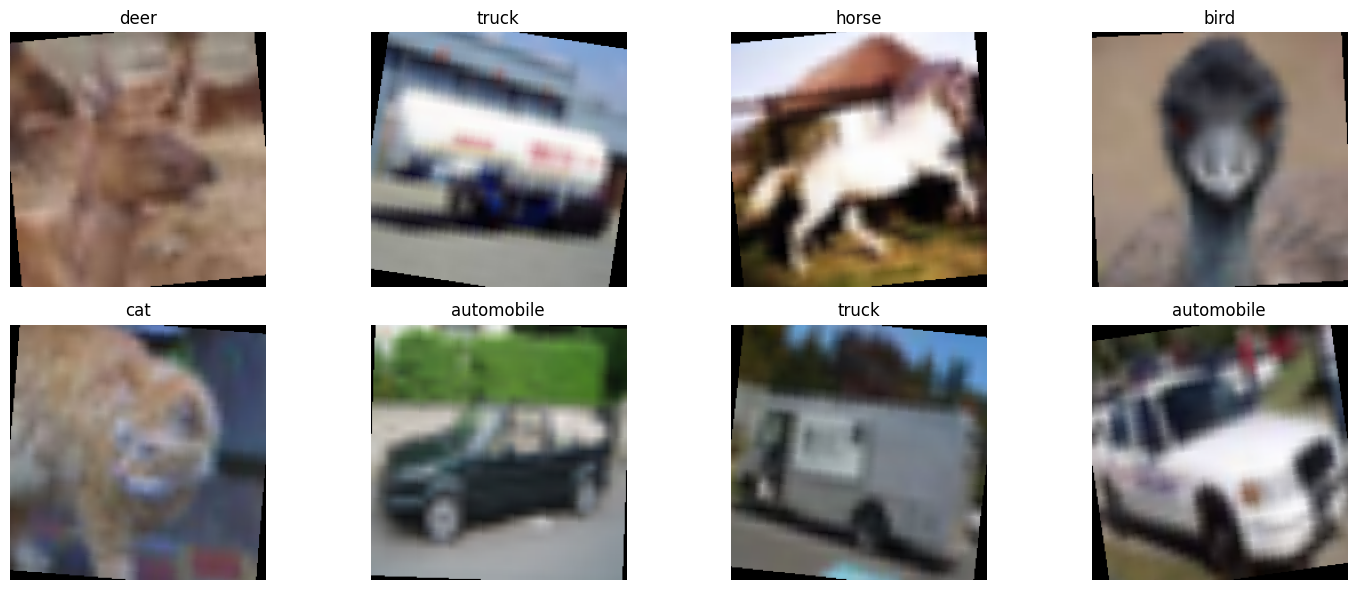

In [6]:
# Visualize some images from the dataset with transformations applied
def imshow(img, title=None):
    # Unnormalize
    img = img.clone()  # avoid modifying tensor in-place
    img = img.squeeze(0) if img.dim() == 4 else img  # remove batch dimension if present

    # Convert from torch tensor to numpy array
    img = img.cpu().numpy().transpose((1, 2, 0))

    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis("off")


# Get a batch of images
images, labels = next(iter(train_loader))

# Plot images
plt.figure(figsize=(15, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i], title=f"{class_names[labels[i]]}")
plt.tight_layout()
plt.show()

## 4. Transfer Learning - Feature Extraction Approach

In this approach, we'll use a pre-trained model as a fixed feature extractor by:

1. Loading the pre-trained model
2. Freezing all its parameters (so they won't be updated during training)
3. Replacing the final layer with a new one tailored to our task
4. Training only the new layer

Let's use ResNet18 for this example:


In [7]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all parameters so we don't backprop through them
for param in model_ft.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes in CIFAR-10
# Resnet's fc layer has shape (in_features=512, out_features=1000)
# We need to change out_features to 10
model_ft.fc = nn.Linear(
    in_features=model_ft.fc.in_features, out_features=len(class_names)
)

# Move model to device
model_ft = model_ft.to(device)

# Print model summary
print("ResNet18 with custom final layer:")
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(
    f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}% of total)"
)
print(f"New output layer: {model_ft.fc}")

ResNet18 with custom final layer:
Total parameters: 11,181,642
Trainable parameters: 5,130 (0.05% of total)
New output layer: Linear(in_features=512, out_features=10, bias=True)


In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model_ft.fc.parameters(), lr=0.001, weight_decay=1e-4
)  # Only optimize the final layer

# Learning rate scheduler to reduce learning rate when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5
)

In [9]:
# Define training and evaluation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    epoch_loss = running_loss / processed_size
    epoch_acc = running_corrects.float() / processed_size

    return epoch_loss, epoch_acc.item() * 100  # Convert accuracy to percentage


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    with torch.inference_mode():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_size += inputs.size(0)

    epoch_loss = running_loss / processed_size
    epoch_acc = running_corrects.float() / processed_size

    return epoch_loss, epoch_acc.item() * 100  # Convert accuracy to percentage

In [10]:
# Training the feature extraction model
def train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler=None, num_epochs=5
):
    # Initialize dictionaries to track metrics
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Training phase
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Evaluation phase
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        # Update scheduler if provided
        if scheduler:
            scheduler.step(test_loss)

        # Record history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        # Print metrics
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%")

        # Deep copy the model if best accuracy
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best test accuracy: {best_acc:.2f}%")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [11]:
# Train the model
model_ft, history_ft = train_model(
    model_ft, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=5
)

Epoch 1/5
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9642 Acc: 68.67%
Test Loss: 0.6535 Acc: 77.84%

Epoch 2/5
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782977b03060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x782977b03060>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

       if w.is_alive(): 
      ^  ^  ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  
  File "/usr/lib/pyth

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782977b03060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782977b03060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.7258 Acc: 75.11%
Test Loss: 0.6469 Acc: 77.41%

Epoch 3/5
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6933 Acc: 76.09%
Test Loss: 0.6085 Acc: 78.91%

Epoch 4/5
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6753 Acc: 76.79%
Test Loss: 0.5862 Acc: 79.56%

Epoch 5/5
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6693 Acc: 76.84%
Test Loss: 0.5808 Acc: 79.86%

Training complete in 10m 52s
Best test accuracy: 79.86%


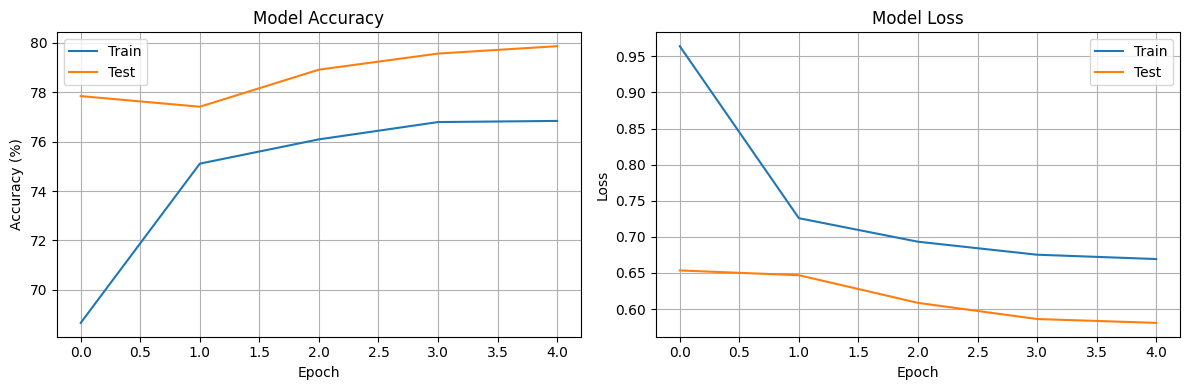

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ft["train_acc"], label="Train")
plt.plot(history_ft["test_acc"], label="Test")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_ft["train_loss"], label="Train")
plt.plot(history_ft["test_loss"], label="Test")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Transfer Learning - Fine-tuning Approach

Now, let's try the fine-tuning approach where we:

1. Load a pre-trained model
2. Replace the final layer
3. Train the entire network, updating all weights

This approach often yields better results but requires more computational resources and is prone to overfitting on small datasets.


In [13]:
# Load pre-trained ResNet18 model
model_ft_full = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Replace the final fully connected layer
num_features = model_ft_full.fc.in_features
model_ft_full.fc = nn.Linear(num_features, len(class_names))

# Move model to the appropriate device
model_ft_full = model_ft_full.to(device)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Using different learning rates for pre-trained and new layers
# Parameters of newly constructed layers have different learning rates
params_to_update = []
params_new = []

# Separate parameters into two groups
for name, param in model_ft_full.named_parameters():
    if "fc" in name:  # New layer
        params_new.append(param)
    else:  # Pre-trained layers
        params_to_update.append(param)

# Create optimizer with different learning rates
optimizer = torch.optim.SGD(
    [
        {
            "params": params_to_update,
            "lr": 0.0001,
            "weight_decay": 1e-4,
        },  # Smaller learning rate for pre-trained layers
        {
            "params": params_new,
            "lr": 0.001,
            "weight_decay": 1e-4,
        },  # Larger learning rate for new layers
    ],
    momentum=0.9,
    weight_decay=1e-4,
    lr=0.001,
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [14]:
# Train the full fine-tuned model
model_ft_full, history_ft_full = train_model(
    model_ft_full,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=5,
)

Epoch 1/5
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7952 Acc: 74.87%
Test Loss: 0.3921 Acc: 87.40%

Epoch 2/5
----------


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:204: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.3701 Acc: 87.70%
Test Loss: 0.2924 Acc: 90.21%

Epoch 3/5
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2989 Acc: 89.93%
Test Loss: 0.2548 Acc: 91.50%

Epoch 4/5
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782977b03060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782977b03060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2580 Acc: 91.21%
Test Loss: 0.2340 Acc: 91.87%

Epoch 5/5
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2342 Acc: 92.12%
Test Loss: 0.2165 Acc: 92.67%

Training complete in 15m 44s
Best test accuracy: 92.67%


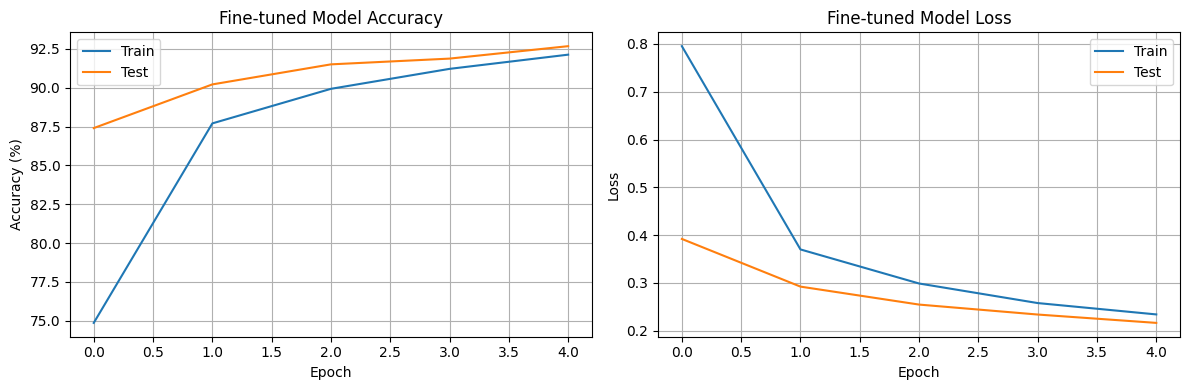

In [15]:
# Plot training history for fine-tuned model
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ft_full["train_acc"], label="Train")
plt.plot(history_ft_full["test_acc"], label="Test")
plt.title("Fine-tuned Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_ft_full["train_loss"], label="Train")
plt.plot(history_ft_full["test_loss"], label="Test")
plt.title("Fine-tuned Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Comparing Feature Extraction and Fine-tuning Approaches

Let's compare the performance of our two approaches:


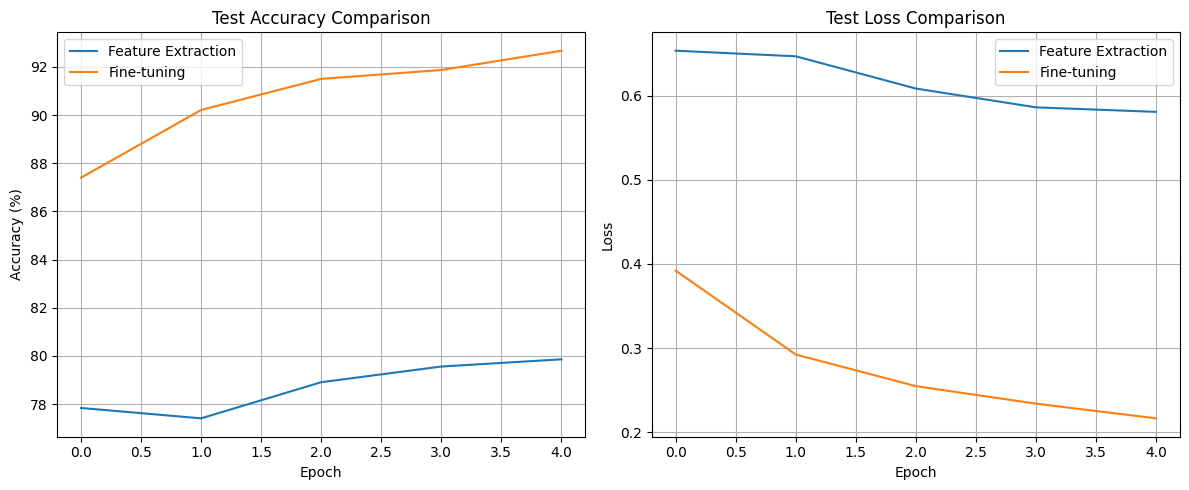

Final metrics:
Feature Extraction - Test Accuracy: 79.86%
Fine-tuning - Test Accuracy: 92.67%


In [16]:
# Plot comparison of both approaches
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ft["test_acc"], label="Feature Extraction")
plt.plot(history_ft_full["test_acc"], label="Fine-tuning")
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_ft["test_loss"], label="Feature Extraction")
plt.plot(history_ft_full["test_loss"], label="Fine-tuning")
plt.title("Test Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print("Final metrics:")
print(f"Feature Extraction - Test Accuracy: {history_ft['test_acc'][-1]:.2f}%")
print(f"Fine-tuning - Test Accuracy: {history_ft_full['test_acc'][-1]:.2f}%")

## 7. Visualizing Predictions

Let's visualize some predictions from our best model:


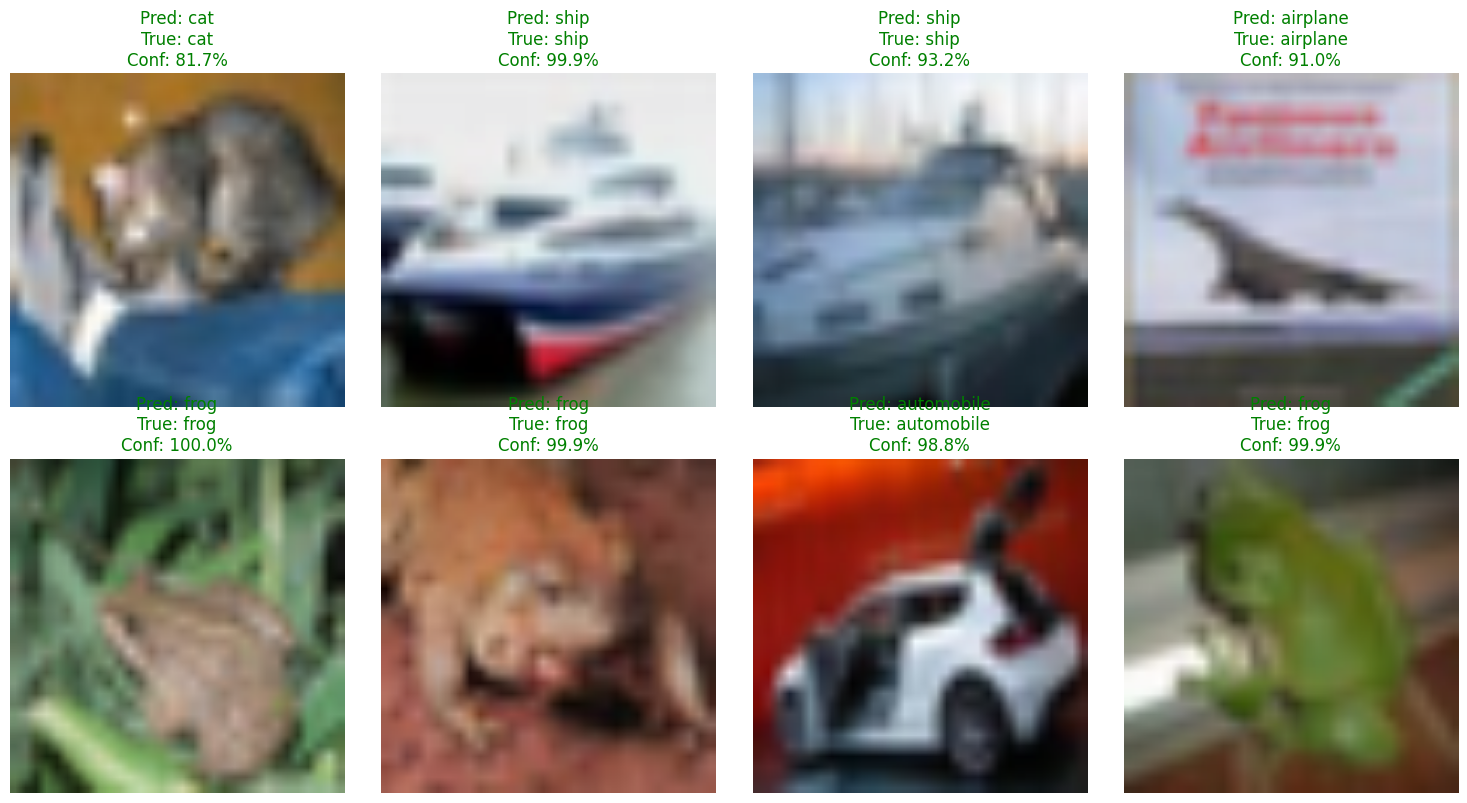

Overall accuracy on test set: 87.50%


In [18]:
# Choose the best model based on performance
best_model = (
    model_ft_full
    if history_ft_full["test_acc"][-1] > history_ft["test_acc"][-1]
    else model_ft
)


# Function to visualize model predictions
def visualize_predictions(model, dataloader, class_names, num_images=8):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 8))

    correct_preds = 0
    total_preds = 0

    with torch.inference_mode():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)

            # Update accuracy counts
            correct_preds += torch.sum(preds == labels.data).item()
            total_preds += inputs.size(0)

            # Plot images
            for j in range(inputs.size(0)):
                if images_so_far < num_images:
                    images_so_far += 1
                    ax = plt.subplot(2, num_images // 2, images_so_far)
                    ax.axis("off")

                    # Get prediction info
                    pred_class = class_names[preds[j]]
                    true_class = class_names[labels[j]]
                    confidence = probs[j][preds[j]].item() * 100

                    # Set title color based on correctness
                    color = "green" if preds[j] == labels[j] else "red"
                    ax.set_title(
                        f"Pred: {pred_class}\nTrue: {true_class}\nConf: {confidence:.1f}%",
                        color=color,
                    )

                    # Display image
                    imshow(inputs.cpu()[j])

                if images_so_far == num_images:
                    return correct_preds / total_preds * 100


# Visualize predictions
accuracy = visualize_predictions(best_model, test_loader, class_names)
plt.tight_layout()
plt.show()

print(f"Overall accuracy on test set: {accuracy:.2f}%")

## 9. Saving and Loading the Model

To deploy our model or use it later, we need to save it:


In [19]:
# Save the best model
model_type = "fine_tuned" if best_model is model_ft_full else "feature_extraction"
model_path = f"models/resnet18_{model_type}_cifar10.pth"

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save model
torch.save(
    {
        "model_state_dict": best_model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "class_names": class_names,
        "model_type": model_type,
    },
    model_path,
)

print(f"Model saved to {model_path}")


# Demo loading the saved model
def load_model(model_path):
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))

    # Initialize model architecture
    model = models.resnet18(weights=None)

    # Adjust final layer based on number of classes
    num_classes = len(checkpoint["class_names"])
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # Load state dict
    model.load_state_dict(checkpoint["model_state_dict"])

    return model, checkpoint["class_names"]


# Load model (for demonstration)
loaded_model, loaded_class_names = load_model(model_path)
loaded_model = loaded_model.to(device)
loaded_model.eval()

print("Model loaded successfully")
print(f"Class names: {loaded_class_names}")

Model saved to models/resnet18_fine_tuned_cifar10.pth
Model loaded successfully
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 10. Summary and Best Practices

### Key Takeaways:

1. **Transfer Learning Approaches**:

   - **Feature Extraction**: Faster to train, uses less computational resources, good for small datasets or when target task is similar to the source task.
   - **Fine-tuning**: Better performance, but requires more data, computational resources, and careful training to avoid overfitting.

2. **Pre-trained Models**: Different architectures have different strengths:

   - **ResNet**: Good balance of performance and efficiency, useful for many tasks.
   - **VGG**: Simple architecture but larger parameter count, useful as a baseline.
   - **MobileNet**: Lightweight, designed for mobile/edge devices.
   - **EfficientNet**: State-of-the-art performance with balanced scaling.

3. **Data Preparation**:
   - Resize images to match the input size of the pre-trained model.
   - Normalize with the same mean and standard deviation as the original training data.
   - Use appropriate data augmentation for the task.

### Best Practices for Transfer Learning:

1. **Dataset Size Considerations**:

   - **Small dataset**: Use feature extraction, freeze most layers.
   - **Medium dataset**: Fine-tune upper layers, freeze lower layers.
   - **Large dataset**: Fine-tune the entire network or consider training from scratch.

2. **Domain Similarity**:

   - If your task is similar to the pre-trained task, more layers can be frozen.
   - If your task is very different, fine-tuning more layers may be beneficial.

3. **Learning Rate Strategy**:

   - Use smaller learning rates for pre-trained layers.
   - Use larger learning rates for new layers.
   - Consider learning rate scheduling to reduce rates over time.

4. **Regularization**:

   - Use dropout and weight decay to prevent overfitting, especially when fine-tuning.
   - Data augmentation is particularly important when fine-tuning on small datasets.

5. **Model Selection**:
   - For tasks with limited resources, use lighter models like MobileNet.
   - For tasks requiring high accuracy, consider deeper models like ResNet50 or EfficientNet.

By applying these principles, you can effectively use transfer learning to solve a wide range of computer vision tasks with limited data and computational resources.

### Further Reading and Resources:

1. [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
2. [CS231n: Transfer Learning](https://cs231n.github.io/transfer-learning/)
3. [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)
4. [A Survey on Transfer Learning](https://www.cse.ust.hk/~qyang/Docs/2009/tkde_transfer_learning.pdf)
5. [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)


## 11. Exercise Ideas

Try these exercises to deepen your understanding of transfer learning:

1. **Compare Different Pre-trained Models**: Try replacing ResNet18 with VGG16, MobileNetV2, or another architecture. Compare their performance and training time.

2. **Custom Dataset**: Apply transfer learning to a different dataset of your choice. Consider datasets like Flowers102, Stanford Dogs, or your own collected images.

3. **Hyperparameter Tuning**: Experiment with different hyperparameters (learning rates, batch sizes, optimizers) and observe their impact on model performance.

4. **Progressive Unfreezing**: Instead of fine-tuning all layers at once, try progressively unfreezing layers from top to bottom during training.

5. **Visualization Techniques**: Implement more advanced visualization techniques like Grad-CAM to understand where your model is focusing when making predictions.

6. **Ensemble Methods**: Create an ensemble of different pre-trained models to improve prediction accuracy.

7. **Deployment**: Export your model to ONNX format and deploy it in a web application or mobile app.
